# Imports

In [1]:
import numpy as np
import itertools
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pixiedust

Pixiedust database opened successfully


# Introduction

Consider the following equation:
$$\Delta_p \Psi(x,y)=-\pi ^2 (1-y) y \sin (\pi  x)-2 \sin (\pi  x)$$

$x \in [0,1],\ y \in [0,1]$ with *Dirichlet* BC: $\Psi(0,y) = 0$, $\Psi(1,y) = 0$, $\Psi(x,0) = 0$ and $\Psi(x,1) = 0$.

For this first attempt, we will take $p=2$.

# Defining functions

## Sigmoid

Sigmoid $\sigma(x) = \frac{1}{1|e^{-x}}$ and its derrivatives.

Sigmoid with parameter $t$
$$ \sigma_t(x) = \frac{1}{1+e^{-tx}}$$

In [2]:
T = 1

In [3]:
def sig(x):
    return 1 / (1 + np.exp(-T*x))

def sig1(x):
    return T * sig(x) * (1 - sig(x))

def sig2(x):
    return T * (sig1(x) - 2*sig(x)*sig1(x))

def sig3(x):
    return T * (sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x)))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

## rhs

The right side of the equation:  $f(x,y) = -\pi ^2 (1-y) y \sin (\pi  x)-2 \sin (\pi  x)$

$$f(x,y) = 6 x (x-1) (1-2 y) + 2 y (y-1) (1-2 y)$$

In [4]:
def f(x, y):
    return -np.pi**2 * (1-y) * y * np.sin(np.pi * x) - 2 * np.sin(np.pi * x)

# def f(x, y):
#     return 6*(x-1)*x*(1-2*y) + 2*(y-1)*y*(1-2*y)

The analytic solution is given by: $\Psi_a(x,y) = y (1-y) \sin(\pi  x)$

$$\Psi_a(x,y) = x (1-x) y (1-y) (1-2 y)$$

In [5]:
def psi_a(x, y):
    return y * (1-y) * np.sin(np.pi * x)

# def psi_a(x, y):
#     return x*(1-x)*y*(1-y)*(1-2*y)

## Neural Network

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [6]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\frac{\partial^k N}{\partial x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [7]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\frac{\partial N}{\partial w_j} = x_j v \sigma '$$

In [8]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [9]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [10]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \frac{\partial}{\partial u} \frac{\partial^k}{\partial x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [11]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \frac{\partial}{\partial v} \frac{\partial^k}{\partial x_j^k} N = w_j^k \sigma^{(k)} $$

In [12]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Cost function

$$E[\vec{p}] = \sum_i \left\{ \frac{\partial N(x_i,y_i)^2}{\partial x^2} + \frac{\partial N(x_i,y_i)^2}{\partial y^2} - f(x_i,y_i) \right\}^2$$

In [13]:
def error(x, y, p):
    return dN_dxj_k(x,y,p,0,2) + dN_dxj_k(x,y,p,1,2) - f(x, y)

In [14]:
def cost(pairs, p):
    loss = []
    for x, y in pairs:
        err_sq = error(x, y, p)**2
        loss.append(err_sq)
    return sum(loss)

In [34]:
def rms_err(points, p):
    err = []
    for x,y in points:
#         if psi_a(x,y) != 0: err.append((psi_a(x,y)-N(x,y,p))**2 / psi_a(x,y))
        err.append((psi_a(x,y)-N(x,y,p))**2)
    return np.sqrt(sum(err) / len (err))

# Gradients

$$ \frac{\partial E[\vec{p}]}{\partial w_j} = 2 \text{ (error) } \left( \frac{\partial}{\partial w_j} \frac{\partial N^2}{\partial x^2} + \frac{\partial}{\partial w_j} \frac{\partial N^2}{\partial y^2} \right) $$

In [16]:
def dE_dwj(x, y, p, j):
    return 2 * error(x,y,p) * (d_dwj_dN2_dxk2(x,y,p,j,0) + d_dwj_dN2_dxk2(x,y,p,j,1))

$$ \frac{\partial E[\vec{p}]}{\partial u} = 2 \text{ (error) } \left( \frac{\partial}{\partial u} \frac{\partial N^2}{\partial x^2} + \frac{\partial}{\partial u} \frac{\partial N^2}{\partial y^2} \right) $$

In [17]:
def dE_du(x, y, p):
        return 2 * error(x,y,p) * (d_du_dkN(x,y,p,0,2) + d_du_dkN(x,y,p,1,2))

$$ \frac{\partial E[\vec{p}]}{\partial v} = 2 \text{ (error) } \left( \frac{\partial}{\partial v} \frac{\partial N^2}{\partial x^2} + \frac{\partial}{\partial v} \frac{\partial N^2}{\partial y^2} \right) $$

In [18]:
def dE_dv(x, y, p):
    return 2 * error(x,y,p) * (d_dv_dkN(x,y,p,0,2) + d_dv_dkN(x,y,p,1,2))

# Training

In [42]:
class NNTrain:
    def __init__(self, nx=10, hidden_nodes=10, lr=0.1, update_interval=50, boundary_points=5):
        self.training_started = False
        self.nx = nx
        self.hidden_nodes = hidden_nodes
        self.lr = lr
        self.update_interval = update_interval
        self.points = list(itertools.product(np.linspace(0, 1, nx), 
                                             np.linspace(0, 1, nx)))
        self.points.extend([(0,i) for i in np.linspace(0,1,nx+boundary_points)])
        self.points.extend([(1,i) for i in np.linspace(0,1,nx+boundary_points)])
        self.points.extend([(i,0) for i in np.linspace(0,1,nx+boundary_points)])
        self.points.extend([(i,1) for i in np.linspace(0,1,nx+boundary_points)])
        self.points = list(set(self.points))
        self.cost_rate = []
        self.rms_err = []
        self.p = np.array([np.random.randn(2,hidden_nodes),
                           np.random.randn(hidden_nodes),
                           np.random.randn(hidden_nodes)])

    def train(self, itr=1000):
        if self.training_started:
            mode='a'
        else:
            mode='w'
        self.training_started=True
        
        with open('output/output.csv', mode) as file:
            if mode=='w':
                file.write('Iteration,Cost,Cost Diff,rms Err, rms Err Diff\n')
            start=len(self.cost_rate)-1
            if start<1:
                start+=1
                self.cost_rate.append(cost(self.points, self.p))
                self.rms_err.append(rms_err(self.points, self.p))

            i = start
            while i < start+itr:
                np.random.shuffle(self.points)
#                 for x, y in self.points: 
#                     self.p[0][0] -= self.lr * dE_dwj(x, y, self.p, 0)
#                     self.p[0][1] -= self.lr * dE_dwj(x, y, self.p, 1)
#                     self.p[1] -= self.lr * dE_du(x, y, self.p)
#                     self.p[2] -= self.lr * dE_dv(x, y, self.p)
                w0 = []
                w1 = []
                u = []
                v = []
                for x, y in self.points:
                    w0.append(dE_dwj(x, y, self.p, 0))
                    w1.append(dE_dwj(x, y, self.p, 1))
                    u.append(dE_du(x, y, self.p))
                    v.append(dE_dv(x, y, self.p))
                self.p[0][0] -= self.lr * sum(w0)
                self.p[0][1] -= self.lr * sum(w1)
                self.p[1] -= self.lr * sum(u)
                self.p[2] -= self.lr * sum(v)
                
                self.cost_rate.append(cost(self.points,self.p))
                cost_diff = self.cost_rate[i]-self.cost_rate[i+1]
                
                self.rms_err.append(rms_err(self.points,self.p))
                rms_err_diff = self.rms_err[i]-self.rms_err[i+1]

                file.write('{},{:.8f},{:.8f},{:.8f},{:.8f}\n'.format(
                    i+1,self.cost_rate[i+1],
                    cost_diff, self.rms_err[i+1], rms_err_diff))

                if i%self.update_interval==0:
                    file.flush()
                    
                i+=1
                
    def save_result(self, output_name=''):
        timestr = time.strftime("%Y%m%d-%H%M")
        np.savez('output/'+ timestr + '_' + output_name +'_nn_params.npz', self.p)
        np.savez('output/'+ timestr + '_' + output_name +'_cost_rate.npz', self.cost_rate)

In [65]:
T=1
test = NNTrain(nx=5, boundary_points=10, hidden_nodes=20, lr=0.0001, update_interval=10)

In [66]:
test.train(itr=10000)

KeyboardInterrupt: 

In [51]:
test.lr = 0.0001

In [57]:
cost(test.points,test.p)

0.6367345113891231

In [53]:
f(0,0)

0

In [54]:
N(0,0,test.p)

2.7195567651544286

In [52]:
error(0,0,test.p)

-0.25081108754573256

In [55]:
psi_a(0,0)

0

<IPython.core.display.Javascript object>


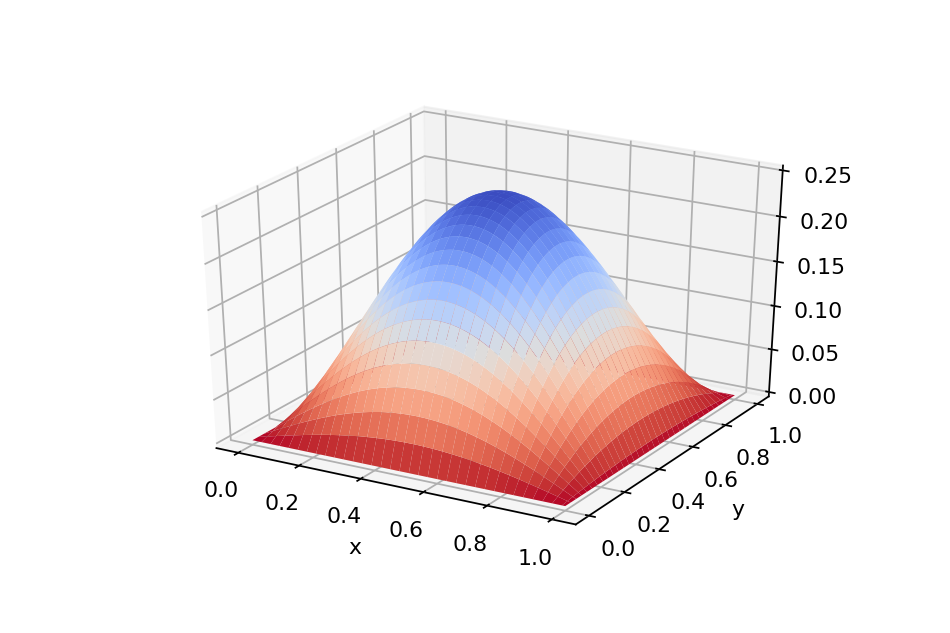

In [60]:
plot_fun(psi_a)

<IPython.core.display.Javascript object>


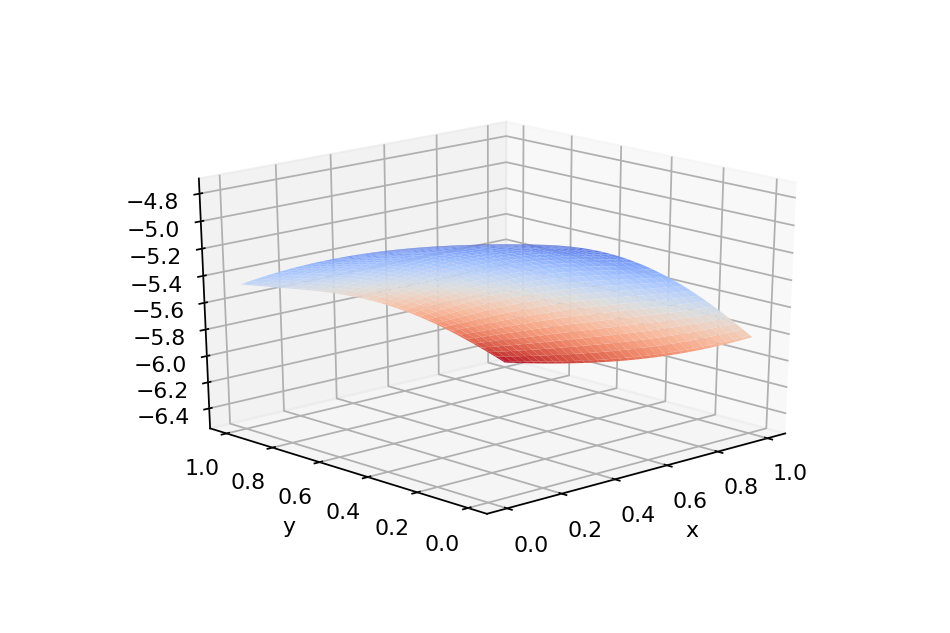

In [59]:
plot_fun(N, p=test.p)

# Graphs

In [55]:
%matplotlib notebook
%matplotlib notebook

## Hidden Nodes

In [56]:
def plot_nodes(p, hmax=10, row=3, col=4):
    d_x=0.1

    fig = plt.figure(figsize=(col*3, row*3), dpi=500)
    for h in range(1,hmax+1):
        ax = fig.add_subplot(row,col,h, projection='3d')
        x = y = np.arange(0, 1+d_x, d_x)
        X, Y = np.meshgrid(x, y)

        zs = np.array([sig(z(x,y,p))[h-1] for x,y in zip(np.ravel(X), np.ravel(Y))])
        Z = zs.reshape(X.shape)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlim(0,1)

        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
        ax.title.set_text('Hidden Node: ' + str(h))
        time.sleep(0.2)

    plt.savefig('all.png')

## Error vs Iterations

In [46]:
def plot_iteration(arr, min_it=0, max_it=None):
    plt.figure()
    plt.plot(np.arange(len(arr[min_it:max_it])), np.array(arr[min_it:max_it]))
    plt.show()

## Solution Accuracy on the domain

In [58]:
def accuracy(p):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([psi_a(x,y)-N(x,y,p) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
#     ax.set_zlabel('Accuracy')

    plt.show()

In [57]:
def plot_fun(fun, zlim=False, title=None, **kwargs):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([fun(x,y,**kwargs) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.title.set_text(title)
    
    if zlim:
        ax.set_zlim(0,1)


    plt.show()